In [23]:
# JarrettDelaney_CourseProjectCode.ipynb
# ENV3040C
# By Delaney Jarrett

In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 

In [78]:
file_1 = "41586_2025_9612_MOESM5_ESM (1).xlsx"
file_2 = "41893_2025_1533_MOESM3_ESM (2).xlsx"  # main data
file_3 = "41893_2025_1533_MOESM5_ESM (1).xlsx"
output_folder = "analysis_outputs"
os.makedirs(output_folder, exist_ok=True)
output_folder

'analysis_outputs'

In [79]:
def preview_excel(path):
    """Print sheet names and first few rows."""
    if not os.path.exists(path):
        print("FILE NOT FOUND:", path)
        return None
    
    print("\n=== Previewing:", path, "===\n")
    xls = pd.ExcelFile(path)
    print("Sheets:", xls.sheet_names)
    
    for sheet in xls.sheet_names:
        df = xls.parse(sheet)
        print(f"\nSheet: {sheet}")
        print("Shape:", df.shape)
        print(df.head())
    
    return xls

# Quick previews (not needed for analysis, just for completeness)
xls1 = preview_excel(file_1)
xls2 = preview_excel(file_2)
xls3 = preview_excel(file_3)


=== Previewing: 41586_2025_9612_MOESM5_ESM (1).xlsx ===

Sheets: ['Figure 2(a) ', 'Figure 2(b)', 'Figure 2(c) ', 'Figure 2(d)', 'Figure 2(e) ', 'Figure 2(f)']

Sheet: Figure 2(a) 
Shape: (203, 2)
  Spatial distributions of PM2.5-linked premature deaths induced by fire emissions (103)  \
0                                      Country codes                                       
1                                                AFG                                       
2                                                ALB                                       
3                                                DZA                                       
4                                                ASM                                       

         Unnamed: 1  
0  Premature deaths  
1          0.144912  
2          0.047753  
3          0.130213  
4          0.000001  

Sheet: Figure 2(b)
Shape: (13105, 3)
  Spatial distributions of all-sky aerosol DRF at TOA from fire Emissions (W m-2

In [80]:
# Load main dataset
xls_m3 = pd.ExcelFile(file_2)
df_m3 = xls_m3.parse("Sheet1")

print("Shape:", df_m3.shape)
df_m3.head()

Shape: (1052, 5)


,...1,LocIDLarge,all_total,fire_PM25_mean,fire_PM25_max
0,1,AUS_10101,18559.0,2.657567,67.073094
1,2,AUS_10102,5097.0,2.542273,140.183429
2,3,AUS_10103,4380.0,2.590551,121.015389
3,4,AUS_10104,21575.0,2.015438,67.485305
4,5,AUS_10201,52772.0,2.423879,86.674113


In [81]:
# Convert to numeric where possible
df = df_m3.copy()
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Rename columns for easier use
df = df.rename(columns={
    "...1": "id",
    "LocIDLarge": "location",
    "all_total": "total_cases",
    "fire_PM25_mean": "pm25_mean",
    "fire_PM25_max": "pm25_max"
})

df.head()

/var/folders/pz/hx4jgbz94455j28m4q5k9nhh0000gn/T/ipykernel_5050/626016362.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


,id,location,total_cases,pm25_mean,pm25_max
0,1,AUS_10101,18559.0,2.657567,67.073094
1,2,AUS_10102,5097.0,2.542273,140.183429
2,3,AUS_10103,4380.0,2.590551,121.015389
3,4,AUS_10104,21575.0,2.015438,67.485305
4,5,AUS_10201,52772.0,2.423879,86.674113


In [82]:
# Select the numeric columns used in analysis
numeric_cols = ["total_cases", "pm25_mean", "pm25_max"]

# Drop missing data
df_main = df[numeric_cols].dropna()

df_main.shape

(1044, 3)

In [83]:
summary_stats = df_main.agg(["mean", "median", "std", "min", "max", "count"]).T
summary_stats

,mean,median,std,min,max,count
total_cases,33819.437261,16718.000000,80861.521907,4.000000,1.168090e+06,1044.0
pm25_mean,3.642136,2.455216,2.939918,0.494429,2.220520e+01,1044.0
pm25_max,42.758095,37.943761,28.846790,9.503755,1.691891e+02,1044.0


In [84]:
# Save summary stats
summary_path = os.path.join(output_folder, "summary_stats.csv")
summary_stats.to_csv(summary_path)
summary_path

'analysis_outputs/summary_stats.csv'

In [85]:
for col in numeric_cols:
    plt.figure()
    plt.hist(df_main[col], bins=30)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {col}")
    plt.tight_layout()
    
    filename = os.path.join(output_folder, f"hist_{col}.png")
    plt.savefig(filename)
    plt.close()
    
    print("Saved:", filename)

Saved: analysis_outputs/hist_total_cases.png
Saved: analysis_outputs/hist_pm25_mean.png
Saved: analysis_outputs/hist_pm25_max.png


In [86]:
x_mean = df_main["pm25_mean"]
x_max = df_main["pm25_max"]
y = df_main["total_cases"]

# pm25_mean vs total_cases
pearson_r_mean, pearson_p_mean = stats.pearsonr(x_mean, y)
spearman_r_mean, spearman_p_mean = stats.spearmanr(x_mean, y)

# pm25_max vs total_cases
pearson_r_max, pearson_p_max = stats.pearsonr(x_max, y)
spearman_r_max, spearman_p_max = stats.spearmanr(x_max, y)

# pm25_mean vs pm25_max
pearson_r_mmm, pearson_p_mmm = stats.pearsonr(x_mean, x_max)

pearson_r_mean, spearman_r_mean, pearson_r_max, spearman_r_max

(np.float64(0.09907625392512878),
 np.float64(0.36271951518183865),
 np.float64(0.03128237198198558),
 np.float64(0.2267894247463511))

In [87]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_mean, y)
r_squared = r_value**2

slope, intercept, r_squared, p_value

(np.float64(2725.0610825565764),
 np.float64(23894.394002163717),
 np.float64(0.009816104091836612),
 np.float64(0.001349190186740113))

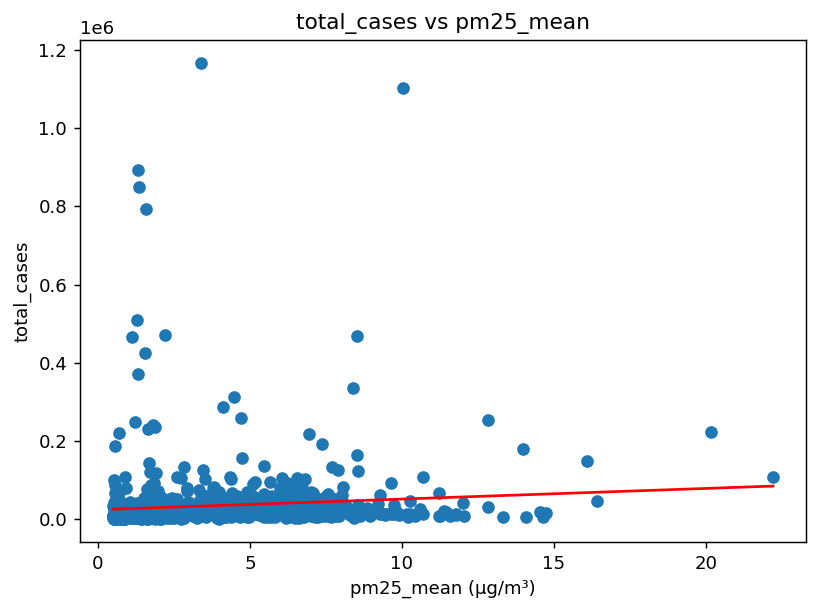

'analysis_outputs/scatter_pm25_mean_vs_total_cases.png'

In [88]:
plt.figure()
plt.scatter(x_mean, y)

# create regression line
x_line = np.linspace(x_mean.min(), x_mean.max(), 100)
y_line = intercept + slope * x_line
plt.plot(x_line, y_line, color="red")

plt.xlabel("pm25_mean (µg/m³)")
plt.ylabel("total_cases")
plt.title("total_cases vs pm25_mean")

plt.tight_layout()

plt.show()

scatter_path = os.path.join(output_folder, "scatter_pm25_mean_vs_total_cases.png")
plt.savefig(scatter_path)
plt.close()

scatter_path

In [89]:
scaler = StandardScaler()
X = scaler.fit_transform(df_main[numeric_cols])

pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
explained_var

array([0.47600878, 0.32857246, 0.19541876])

In [90]:
pc1_weights = pd.Series(pca.components_[0], index=numeric_cols)
pc1_weights

total_cases    0.211812
pm25_mean      0.699597
pm25_max       0.682422
dtype: float64

In [91]:
# Save PC1 weights
pc1_weights.to_csv(os.path.join(output_folder, "pc1_weights.csv"))

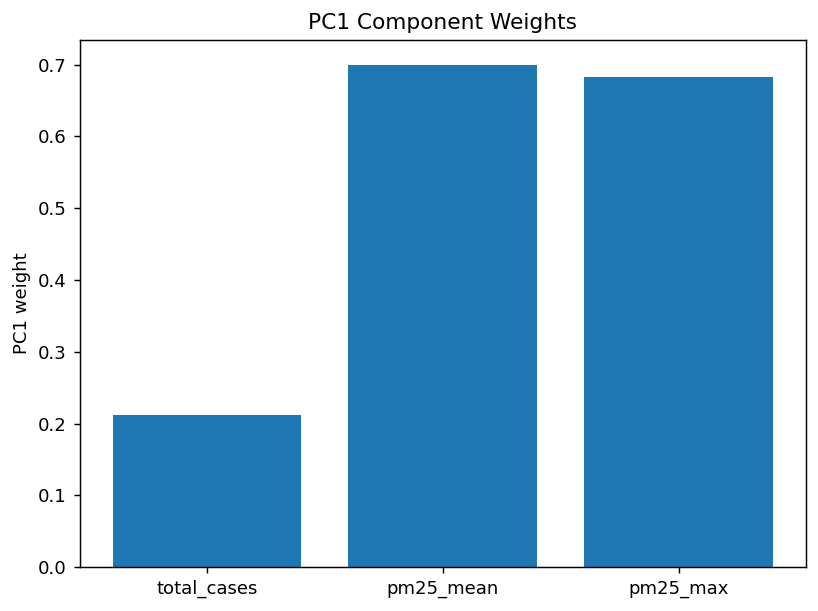

'analysis_outputs/pc1_weights_bar.png'

In [92]:
plt.figure()
plt.bar(numeric_cols, pc1_weights.values)
plt.ylabel("PC1 weight")
plt.title("PC1 Component Weights")
plt.tight_layout()

plt.show()

filename = os.path.join(output_folder, "pc1_weights_bar.png")
plt.savefig(filename)
plt.close()

filename

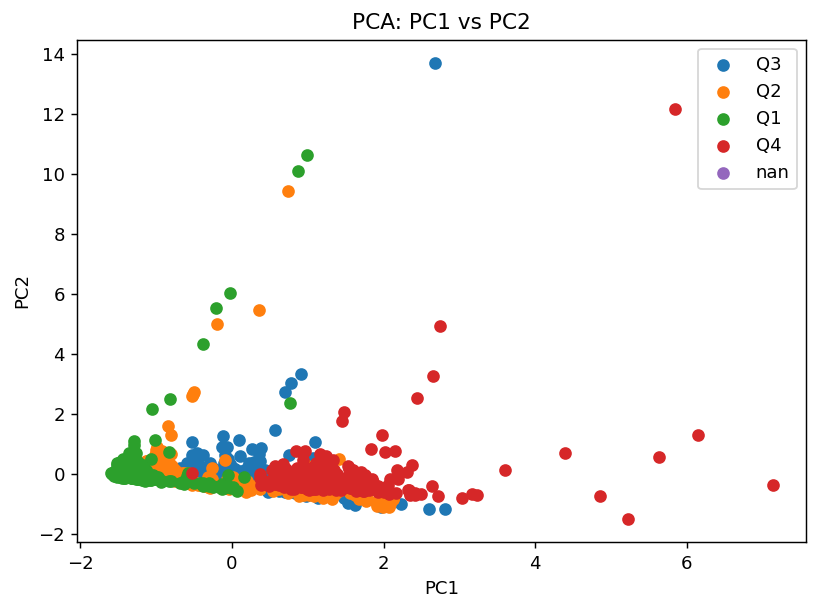

'analysis_outputs/pca_pc1_pc2.png'

In [93]:
# PCA scatter
pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3"])
groups = pd.qcut(df_main["pm25_mean"], 4, labels=["Q1","Q2","Q3","Q4"])
pc_df["pm25_group"] = groups

plt.figure()
for g in pc_df["pm25_group"].unique():
    mask = pc_df["pm25_group"] == g
    plt.scatter(pc_df.loc[mask, "PC1"], pc_df.loc[mask, "PC2"], label=str(g))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2")
plt.legend()
plt.tight_layout()

plt.show()

pca_path = os.path.join(output_folder, "pca_pc1_pc2.png")
plt.savefig(pca_path)
plt.close()

pca_path